In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib
from distutils.version import LooseVersion

In [2]:
# 1. import data
trainfile = "Kaggle-Give-Me-Some-Data/cs-training.csv"
testfile = "Kaggle-Give-Me-Some-Data/cs-test.csv"
train_df = pd.read_csv(trainfile)
test_df = pd.read_csv(testfile)
train_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# 2. filling missing values
train_df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [5]:
train_df["MonthlyIncome"].fillna(train_df["MonthlyIncome"].mean(), inplace=True)
train_df["NumberOfDependents"].fillna(train_df["NumberOfDependents"].mean(), inplace=True)

In [6]:
train_df.isnull().sum()

Unnamed: 0                              0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [7]:
# standardize the data
train_df = train_df.drop(columns=["Unnamed: 0"])
train_y = train_df["SeriousDlqin2yrs"].values
train_features = train_df.drop(columns=["SeriousDlqin2yrs"]).columns.tolist()
train_X = train_df.drop(columns=["SeriousDlqin2yrs"]).values

In [8]:
sc = StandardScaler()
sc.fit(train_X)
train_X_std = sc.transform(train_X)
# test_X_std = sc.transform(test_X)

In [9]:
# 3. feature selection
for c in [50, 10, 1, 0.1, 0.01]:
    lri = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear')
    lri.fit(train_X_std, train_y)
    import_n = lri.coef_[lri.coef_ != 0].shape[0]
    print(f"C = {c}, import_n = {import_n}")

C = 50, import_n = 10
C = 10, import_n = 10
C = 1, import_n = 10
C = 0.1, import_n = 10
C = 0.01, import_n = 9


In [10]:
for c in [0.005, 0.001, 0.0005, 0.0001]:
    lri = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear')
    lri.fit(train_X_std, train_y)
    import_n = lri.coef_[lri.coef_ != 0].shape[0]
    print(f"C = {c}, import_n = {import_n}")

C = 0.005, import_n = 8
C = 0.001, import_n = 3
C = 0.0005, import_n = 2
C = 0.0001, import_n = 0


In [11]:
lr = LogisticRegression(penalty='l1', C=0.0005, random_state=1, solver='liblinear')
lr.fit(train_X_std, train_y)
important_idx = [i for i in range(len(train_features)) if lr.coef_[0][i] != 0]
print("important features: ", [train_features[i] for i in important_idx])

important features:  ['age', 'NumberOfTime30-59DaysPastDueNotWorse']


In [34]:
# 4. SVM model
from sklearn.svm import SVC
svm = SVC(kernel='linear', random_state=1, C=0.001)    # when C is larger, the model has less violation 
train_X_important = train_X_std[:, important_idx]
svm.fit(train_X_important, train_y)

SVC(C=0.001, kernel='linear', random_state=1)

In [18]:
# 5. plot
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface 
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

C:\Users\zqy\AppData\Local\Temp\ipykernel_8948\3556586569.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


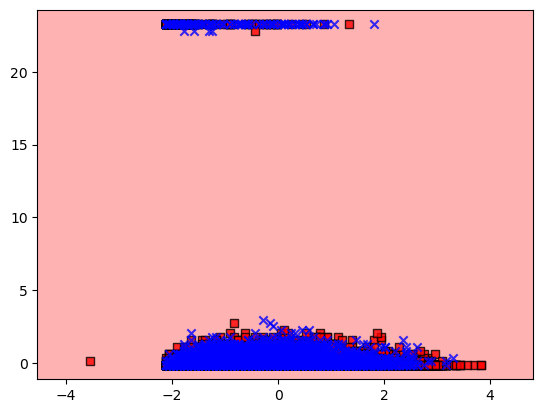

In [44]:
plot_decision_regions(train_X_important, train_y, svm, test_idx=None, resolution=0.02)

In [12]:
np.unique(train_y, return_counts=True)

(array([0, 1], dtype=int64), array([139974,  10026], dtype=int64))

The plot is a little strange, and I can find that the sample is imbalanced, so I try to balance the sample.

In [44]:
# 6. balance the sample
from sklearn.utils import resample
print('Number of class 1 examples before:', train_X_std[train_y == 1].shape[0])

X_upsampled, y_upsampled = resample(train_X_std[train_y == 1],
                                    train_y[train_y == 1],
                                    replace=True,
                                    n_samples=train_X_std[train_y == 0].shape[0],
                                    random_state=1)

print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples before: 10026
Number of class 1 examples after: 139974


In [47]:
train_X_balanced = np.vstack((train_X_std[train_y == 0], X_upsampled))
train_y_balanced = np.hstack((train_y[train_y == 0], y_upsampled))

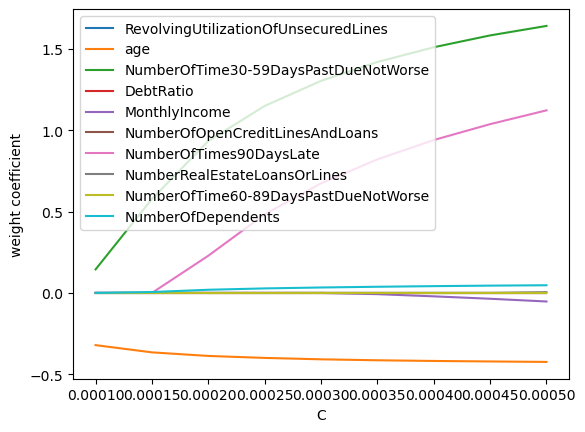

In [48]:
# feature selection
weights, params = [], []
for c in np.linspace(0.0001, 0.0005, 9):
    lri = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear')
    lri.fit(train_X_balanced, train_y_balanced)
    weights.append(lri.coef_[0])
    params.append(c)

weights = np.array(weights)
for i in range(weights.shape[1]):
    plt.plot(params, weights[:, i], label=train_features[i])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()

Using the balanced sample, we can find that the important features are also "age" and "numberoftime30-59dayspastduenotworse".

In [80]:
# 4. SVM model
from sklearn.svm import SVC
train_X_bl_important = train_X_balanced[:, important_idx]
svm = SVC(kernel='linear', random_state=1, C=0.001)    # when C is larger, the model has less violation 
svm.fit(train_X_bl_important, train_y_balanced)

SVC(C=0.001, kernel='linear', random_state=1)

Because SVM's training time is very long, I will try to use desicion tree to train the model and tune the parameters.

C:\Users\zqy\AppData\Local\Temp\ipykernel_2540\3556586569.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


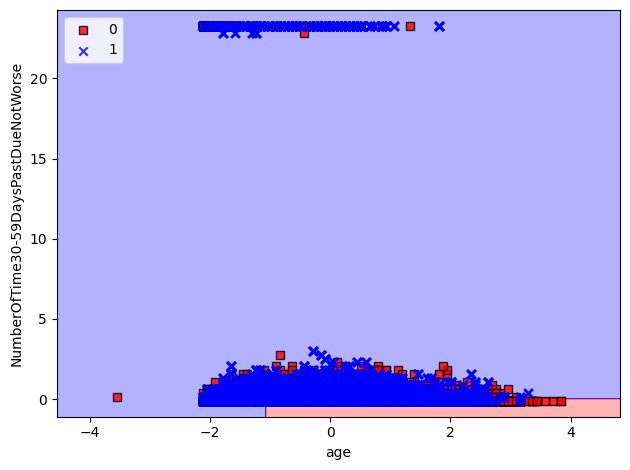

In [49]:
# 7. decision tree
from sklearn.tree import DecisionTreeClassifier
train_X_bl_important = train_X_balanced[:, important_idx]
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(train_X_bl_important, train_y_balanced)

plot_decision_regions(train_X_bl_important, train_y_balanced, 
                      classifier=tree_model,
                      resolution=0.02)

plt.xlabel('age') 
plt.ylabel('NumberOfTime30-59DaysPastDueNotWorse')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [51]:
# 8. tune the parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

gs = GridSearchCV(estimator=DecisionTreeClassifier(criterion='gini', 
                                    random_state=1),
                  param_grid=param_grid, 
                  scoring='accuracy',
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(train_X_bl_important, train_y_balanced)


In [52]:
for mean_score, params in zip(gs.cv_results_['mean_test_score'], gs.cv_results_['params']):
    print(params, '->', mean_score)

{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'splitter': 'best'} -> 0.6809121712007202
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2, 'splitter': 'random'} -> 0.5114842413288292
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3, 'splitter': 'best'} -> 0.6809121712007202
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 3, 'splitter': 'random'} -> 0.5114842413288292
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 4, 'splitter': 'best'} -> 0.6809121712007202
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 4, 'splitter': 'random'} -> 0.5114842413288292
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'splitter': 'best'} -> 0.6809121712007202
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5, 'splitter': 'random'} -> 0.5114842413288292
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 6, 'splitter': 'best'} -> 0.6809121712007202
{'criterion': 'gini', 'max_depth': 1, 'min_samples_split

In [53]:
print(gs.best_score_)
print(gs.best_params_)

0.6912605193905059
{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2, 'splitter': 'best'}
